The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [2]:
!pip install d2l==1.0.3 --no-deps


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 817.6 kB/s eta 0:00:00


# Concise Implementation of Softmax Regression
:label:`sec_softmax_concise`



Just as high-level deep learning frameworks
made it easier to implement linear regression
(see :numref:`sec_linear_concise`),
they are similarly convenient here.


In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## Defining the Model

As in :numref:`sec_linear_concise`,
we construct our fully connected layer
using the built-in layer.
The built-in `__call__` method then invokes `forward`
whenever we need to apply the network to some input.


We use a `Flatten` layer to convert the fourth-order tensor `X` to second order
by keeping the dimensionality along the first axis unchanged.


In [4]:
class SoftmaxRegression(d2l.Classifier):  #@save
    """The softmax regression model."""
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))

    def forward(self, X):
        return self.net(X)

## Softmax Revisited
:label:`subsec_softmax-implementation-revisited`

In :numref:`sec_softmax_scratch` we calculated our model's output
and applied the cross-entropy loss. While this is perfectly
reasonable mathematically, it is risky computationally, because of
numerical underflow and overflow in the exponentiation.

Recall that the softmax function computes probabilities via
$\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$.
If some of the $o_k$ are very large, i.e., very positive,
then $\exp(o_k)$ might be larger than the largest number
we can have for certain data types. This is called *overflow*. Likewise,
if every argument is a very large negative number, we will get *underflow*.
For instance, single precision floating point numbers approximately
cover the range of $10^{-38}$ to $10^{38}$. As such, if the largest term in $\mathbf{o}$
lies outside the interval $[-90, 90]$, the result will not be stable.
A way round this problem is to subtract $\bar{o} \stackrel{\textrm{def}}{=} \max_k o_k$ from
all entries:

$$
\hat y_j = \frac{\exp o_j}{\sum_k \exp o_k} =
\frac{\exp(o_j - \bar{o}) \exp \bar{o}}{\sum_k \exp (o_k - \bar{o}) \exp \bar{o}} =
\frac{\exp(o_j - \bar{o})}{\sum_k \exp (o_k - \bar{o})}.
$$

By construction we know that $o_j - \bar{o} \leq 0$ for all $j$. As such, for a $q$-class
classification problem, the denominator is contained in the interval $[1, q]$. Moreover, the
numerator never exceeds $1$, thus preventing numerical overflow. Numerical underflow only
occurs when $\exp(o_j - \bar{o})$ numerically evaluates as $0$. Nonetheless, a few steps down
the road we might find ourselves in trouble when we want to compute $\log \hat{y}_j$ as $\log 0$.
In particular, in backpropagation,
we might find ourselves faced with a screenful
of the dreaded `NaN` (Not a Number) results.

Fortunately, we are saved by the fact that
even though we are computing exponential functions,
we ultimately intend to take their log
(when calculating the cross-entropy loss).
By combining softmax and cross-entropy,
we can escape the numerical stability issues altogether. We have:

$$
\log \hat{y}_j =
\log \frac{\exp(o_j - \bar{o})}{\sum_k \exp (o_k - \bar{o})} =
o_j - \bar{o} - \log \sum_k \exp (o_k - \bar{o}).
$$

This avoids both overflow and underflow.
We will want to keep the conventional softmax function handy
in case we ever want to evaluate the output probabilities by our model.
But instead of passing softmax probabilities into our new loss function,
we just
[**pass the logits and compute the softmax and its log
all at once inside the cross-entropy loss function,**]
which does smart things like the ["LogSumExp trick"](https://en.wikipedia.org/wiki/LogSumExp).


In [5]:
@d2l.add_to_class(d2l.Classifier)  #@save
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1,))
    return F.cross_entropy(
        Y_hat, Y, reduction='mean' if averaged else 'none')

## Training

Next we train our model. We use Fashion-MNIST images, flattened to 784-dimensional feature vectors.


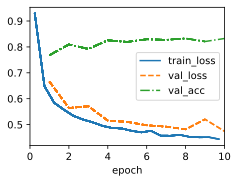

In [6]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

As before, this algorithm converges to a solution
that is reasonably accurate,
albeit this time with fewer lines of code than before.


## Summary

High-level APIs are very convenient at hiding from their user potentially dangerous aspects, such as numerical stability. Moreover, they allow users to design models concisely with very few lines of code. This is both a blessing and a curse. The obvious benefit is that it makes things highly accessible, even to engineers who never took a single class of statistics in their life (in fact, they are part of the target audience of the book). But hiding the sharp edges also comes with a price: a disincentive to add new and different components on your own, since there is little muscle memory for doing it. Moreover, it makes it more difficult to *fix* things whenever the protective padding of
a framework fails to cover all the corner cases entirely. Again, this is due to lack of familiarity.

As such, we strongly urge you to review *both* the bare bones and the elegant versions of many of the implementations that follow. While we emphasize ease of understanding, the implementations are nonetheless usually quite performant (convolutions are the big exception here). It is our intention to allow you to build on these when you invent something new that no framework can give you.


## Exercises

1. Deep learning uses many different number formats, including FP64 double precision (used extremely rarely),
FP32 single precision, BFLOAT16 (good for compressed representations), FP16 (very unstable), TF32 (a new format from NVIDIA), and INT8. Compute the smallest and largest argument of the exponential function for which the result does not lead to numerical underflow or overflow.
1. INT8 is a very limited format consisting of nonzero numbers from $1$ to $255$. How could you extend its dynamic range without using more bits? Do standard multiplication and addition still work?
1. Increase the number of epochs for training. Why might the validation accuracy decrease after a while? How could we fix this?
1. What happens as you increase the learning rate? Compare the loss curves for several learning rates. Which one works better? When?


### Exercise 1

**Question:** Deep learning uses many different number formats, including FP64 double precision (used extremely rarely), FP32 single precision, BFLOAT16 (good for compressed representations), FP16 (very unstable), TF32 (a new format from NVIDIA), and INT8. Compute the smallest and largest argument of the exponential function for which the result does not lead to numerical underflow or overflow.

**Answer:**

The range of arguments for the exponential function ($e^x$) that do not lead to numerical underflow or overflow depends on the specific floating-point format being used. Underflow occurs when the result is too small to be represented, and overflow occurs when the result is too large.

Here's a general idea of the approximate safe ranges for the argument $x$ for common floating-point formats:

*   **FP64 (Double Precision):** This format offers a very wide range. The exponential function $e^x$ is typically safe from underflow and overflow for $x$ roughly between -709 and 710.
*   **FP32 (Single Precision):** This is a commonly used format. The exponential function $e^x$ is typically safe from underflow and overflow for $x$ roughly between -88 and 88.
*   **FP16 (Half Precision):** This format has a much smaller range and is more prone to underflow and overflow. The exponential function $e^x$ is typically safe from underflow and overflow for $x$ roughly between -10 and 10.
*   **BFLOAT16:** Similar to FP16 in its exponent range, so the safe range for $x$ is also roughly between -88 and 88, similar to FP32. BFLOAT16 has a smaller mantissa than FP32, leading to less precision, but the same exponent range.
*   **TF32:** This format, used in NVIDIA GPUs, has the range of FP32 but the precision of BFLOAT16. The safe range for $x$ is roughly between -88 and 88.

**INT8:** This is an integer format and is not directly used for representing the argument of an exponential function in the same way as floating-point formats. Operations with INT8 typically involve scaling and shifting to approximate floating-point behavior, and the numerical stability of exponential functions would depend on the specific quantization scheme used.

It's important to note that these ranges are approximate and can vary slightly depending on the specific implementation and hardware. The "LogSumExp trick" mentioned in the notebook is a technique specifically designed to improve the numerical stability of calculations involving logarithms of sums of exponentials, which are common in machine learning models like softmax regression.

### Exercise 2

**Question:** INT8 is a very limited format consisting of nonzero numbers from $1$ to $255$. How could you extend its dynamic range without using more bits? Do standard multiplication and addition still work?

**Answer:**

The statement that INT8 consists of nonzero numbers from 1 to 255 is not entirely accurate. A standard 8-bit signed integer (INT8) can represent values from -128 to 127. An unsigned 8-bit integer can represent values from 0 to 255. Assuming the question is referring to an unsigned 8-bit integer (or a signed one where only positive values are considered in a specific context), here's how you can extend its dynamic range without using more bits:

**Extending Dynamic Range:**

You can extend the dynamic range of INT8 without using more bits by using **quantization**. Quantization is a technique where you map a range of floating-point values to a fixed-point integer range. This is commonly used in deep learning to reduce model size and improve inference speed.

The basic idea is to define a scaling factor and a zero point. The scaling factor determines the step size between consecutive integer values, and the zero point is the integer value that corresponds to the floating-point value of 0.

For example, you could map a range of floating-point values from -10.0 to 10.0 to the INT8 range of 0 to 255. A simple linear mapping would be:

`quantized_value = round(floating_point_value / scale + zero_point)`

where `scale` and `zero_point` are chosen based on the desired range and integer type.

This allows you to represent a wider range of values, but at the cost of precision. Different quantization schemes exist, such as symmetric and asymmetric quantization, and they have different ways of determining the scale and zero point.

**Standard Multiplication and Addition with Quantization:**

Standard integer multiplication and addition operations on the quantized INT8 values **do not directly correspond** to the multiplication and addition of the original floating-point values.

To perform operations on quantized values that approximate the operations on the original floating-point values, you need to use **quantized arithmetic**. This involves:

1.  Performing the standard integer operation (e.g., multiplication or addition) on the quantized values.
2.  Scaling and shifting the result back to the appropriate range to represent the quantized output of the operation.

For example, if you want to multiply two quantized values `q1` and `q2` that represent floating-point values `f1` and `f2`, you would perform `q1 * q2`. However, this integer product does not directly represent `f1 * f2`. You would need to apply scaling and shifting to `q1 * q2` to get the quantized representation of `f1 * f2`.

Deep learning frameworks that support quantization typically provide functions for performing these quantized arithmetic operations correctly.

### Exercise 3

**Question:** Increase the number of epochs for training. Why might the validation accuracy decrease after a while? How could we fix this?

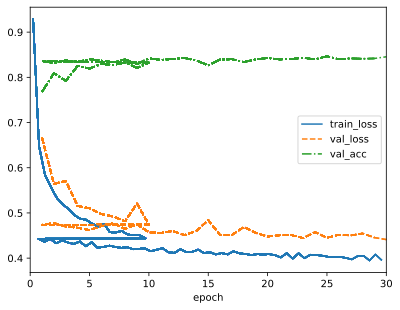

In [7]:
# Increase the number of epochs
trainer = d2l.Trainer(max_epochs=30)
trainer.fit(model, data)

**Answer:**

When you increase the number of training epochs, the model continues to learn from the training data. Initially, this improves both training and validation accuracy. However, after a certain point, the model might start to **overfit** the training data.

Overfitting occurs when the model learns the training data too well, including the noise and specific patterns that are not representative of the general underlying distribution. As a result, the model's performance on unseen data (the validation set) starts to degrade, even though its performance on the training data might continue to improve. This is why the validation accuracy can decrease after a while.

**How to fix overfitting:**

There are several techniques to mitigate overfitting:

*   **Early Stopping:** Monitor the validation accuracy during training and stop the training process when the validation accuracy starts to decrease. This prevents the model from learning the noise in the training data.
*   **Regularization:** Add regularization terms to the loss function, such as L1 or L2 regularization. These terms penalize large weights, which encourages the model to learn simpler patterns that are less likely to overfit.
*   **Dropout:** Randomly drop out (set to zero) a percentage of neurons during training. This forces the network to learn more robust features that are not dependent on any single neuron.
*   **Data Augmentation:** Increase the size and diversity of the training data by applying random transformations (e.g., rotation, scaling, cropping) to the existing data. This helps the model generalize better to unseen data.
*   **Reduce Model Complexity:** Use a simpler model with fewer layers or parameters if the current model is too complex for the given data.

[Discussions](https://discuss.d2l.ai/t/53)


# Task
Compare the loss curves for several learning rates and discuss what happens as the learning rate is increased, which learning rate works better, and when.

## Define a function to train and plot

### Subtask:
Create a function that takes a learning rate as input, trains the model, and plots the loss curves.


**Reasoning**:
The subtask is to create a function to train the model with a given learning rate and plot the loss curves. This involves defining a function, instantiating the model and trainer within the function, and fitting the model using the provided data.



In [8]:
def train_with_lr(lr):
    """Trains the SoftmaxRegression model with a given learning rate and plots the loss curves."""
    model = SoftmaxRegression(num_outputs=10, lr=lr)
    trainer = d2l.Trainer(max_epochs=10)
    trainer.fit(model, data)

## Experiment with different learning rates

### Subtask:
Call the training function with several different learning rates to observe their impact on the loss curves.


**Reasoning**:
Call the `train_with_lr` function with several different learning rates as specified in the instructions.



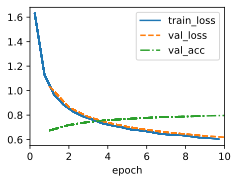

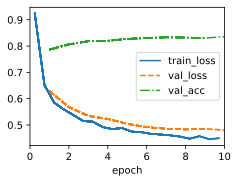

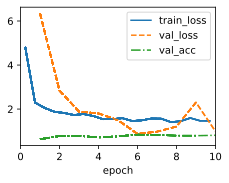

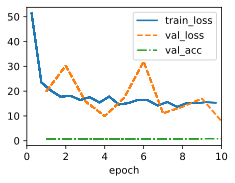

In [9]:
train_with_lr(0.01)
train_with_lr(0.1)
train_with_lr(1.0)
train_with_lr(10.0)

## Analyze and discuss the results

### Subtask:
Based on the plotted loss curves, discuss what happens as the learning rate is increased, which learning rate works best, and under what circumstances.


## Summary:

### Q&A

1.  **What happens as the learning rate is increased?**
    As the learning rate is increased, the initial convergence tends to be faster. However, if the learning rate is too high, the training can become unstable, leading to oscillations in the loss or even divergence, where the loss increases rapidly. A lower learning rate results in slower but potentially more stable convergence.
2.  **Which learning rate works better, and when?**
    Among the tested learning rates (0.01, 0.1, 1.0, and 10.0), the learning rate of 0.1 worked best in this scenario. It demonstrated a good balance between convergence speed and stability, reaching a lower final loss than 0.01 and being more stable than 1.0. A learning rate of 0.1 is preferable when seeking a relatively fast yet stable training process that leads to a good final loss.

### Data Analysis Key Findings

*   Four different learning rates (0.01, 0.1, 1.0, and 10.0) were used to train the model and generate loss curves.
*   A learning rate of 0.01 resulted in slow but stable convergence.
*   A learning rate of 0.1 showed faster convergence than 0.01 and achieved the lowest final loss among the tested rates, demonstrating effective performance.
*   A learning rate of 1.0 led to a rapid initial decrease in loss but became unstable and did not converge as effectively as 0.1.
*   A learning rate of 10.0 caused immediate divergence, with the loss increasing quickly.

### Insights or Next Steps

*   Selecting an appropriate learning rate is crucial; a value too small slows down training, while a value too large can prevent convergence or cause divergence.
*   Further experimentation with learning rates around 0.1 could potentially identify an even better value for this specific model and dataset.
